# Plotting bar charts in Jupyter

__Craig Stuart Sapp__
<br> 3 May 2018

[JupyterLab](https://jupyterlab.readthedocs.io/en/stable/) (development version of jupyter) is a web interface for interactive programming (like the terminal).  This jupyter notebook demonstrates how to load data from Humdrum files extracted with a command pipeline for plotting or otherwise analyze the data further within a jupyter notebook.

Note that [humdrum tools](https://github.com/humdrum-tools/humdrum-tools) has to be installed already and visible in the command-path to run the above command pipeline.

## Loading data from the command-line

Below is an example of how to load data into jupyter from a shell command.  The command follows the `!` character near the start of the line in the cell below.  The result of the pipeline is stored as a list of strings, one for each line of text, in a variable called *input*.  The second line of the following cell causes the first 20 entries of the *input* variable to be shown, which is useful for checking on problems within the command pipeline.

In [104]:
input = ! humcat -s h://chorales | deg -at | serialize | ridx -H | egrep -v "=|r" 
print(input[0:20])

['1', '1', '6', '7', '1', '5', '6', '4', '3', '2', '1', '5', '1', '7', '1', '2', '3', '4', '5', '1']


The steps along the command pipeline are:

<p align="left">command | <p align="left">meaning 
:--- | :--- 
<p align="left"><tt>[humcat](http://extras.humdrum.org/man/humcat) -s h://chorales</tt></p> | <p align="left">Download all of the Bach chorales as a series of Humdrum data segments (one for each chorale; without <tt>-s</tt> they would be merged into a single very long Humdrum sequence).
<p align="left"><tt>[deg](http://www.humdrum.org/Humdrum/commands/deg.html) -at</tt> | <p align="left">Convert the <tt>**kern</tt> data into scale degrees.  The <tt>-a</tt> option removes direction information from the previous note, and the <tt>-t</tt> option does not repeat the scale degree information on a secondary tied notes.
<p align="left"><tt>[serialize](http://extras.humdrum.org/man/serialize)</tt> | <p align="left">Convert the polyphonic score into a serial sequence of parts.
<p align="left"><tt>[ridx](http://extras.humdrum.org/man/ridx) -H</tt> | <p align="left">Remove Humdrum syntax, leaving only data tokens (no null token lines either).
<p align="left"><tt>[egrep](https://www.ibm.com/support/knowledgecenter/en/ssw_aix_72/com.ibm.aix.cmds2/egrep.htm) -v "=&#124;r"</tt> | <p align="left">Remove text lines barlines barlines or rests.


The data extracted from the Bach chorales is a list of the scale degrees for all notes in the `h://chorales` data set.  In other words, given the primary key of each chorale (not keeping track of modulations), what are the counts of notes by scale degree sung by each voice?

To see a list of all unique tokens in the input list:

In [2]:
unique = sorted(list(set(input)))
print(unique)

['1', '1+', '1-', '2', '2+', '2-', '3', '3+', '3-', '4', '4+', '4-', '5', '5+', '5-', '6', '6+', '6-', '7', '7-']


Scale degrees with a minus sign after them mean a semitone lower than in the scale (such as `3-` meaning E-flat in C major, where `3` means E).  And a plus following the scale-degree digit means higher by a semitone. Notice that one scale degree alteration case is missing...  

Here is an example of how to get a list of each scale degree and how often it occurs in the data:

## Plot category frequency data with pandas

The [pandas library](https://pandas.pydata.org/) is useful for working with arrays of data, and it also has an interface to [matplotlib](https://matplotlib.org/), which is the main plotting library for python. To use *pandas*, first load the library with the following command:

In [4]:
import pandas as pd

Now that the data has been loaded into the notebook in the previous section, convert the `input`  list into a pandas [Series](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html) object, and then plot by how often each scale degree occurs:

In [5]:
series = pd.Series(data=input)

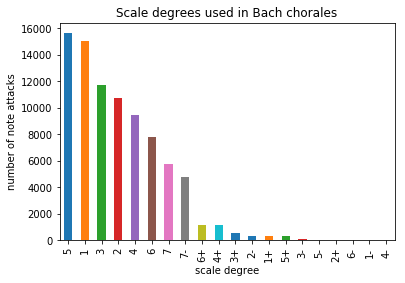

In [12]:
ax = series.value_counts().plot.bar(title="Scale degrees used in Bach chorales")
ax.set_xlabel("scale degree")
ax.set_ylabel("number of note attacks");

Here is an example of how to change the size of the plot by adding the *figsize* paramter to *bar()*.  The units of the width and height values are in inches, although the plot will be scaled to the width of the cell if it is large:

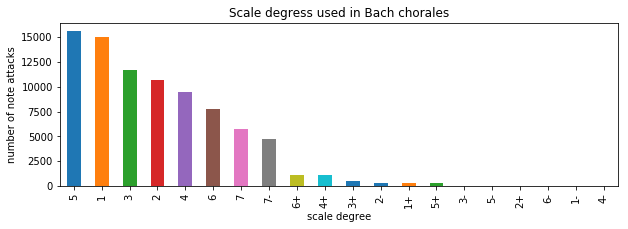

In [13]:
ax = series.value_counts().plot.bar(figsize=(10, 3))
ax.set_title("Scale degress used in Bach chorales")
ax.set_xlabel("scale degree")
ax.set_ylabel("number of note attacks");

To display the counts as fractional frequencies, add `normalize=True` to the `value_counts()` function:

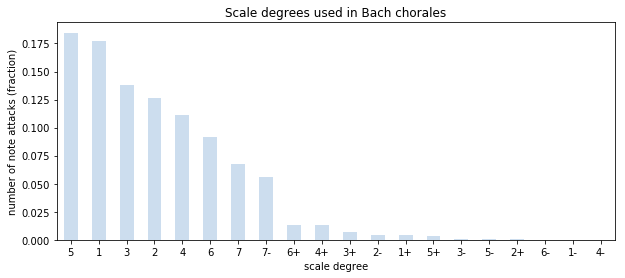

In [14]:
ax = (series.value_counts(normalize=True)
      .plot.bar(rot=0, figsize=(10,4), color="#ccddee"))
ax.set_xlabel("scale degree")
ax.set_ylabel("number of note attacks (fraction)")
ax.set_title("Scale degrees used in Bach chorales");

The rare cases are hard to see, so if needed, you can scale the vertical axis logarithmically like this:

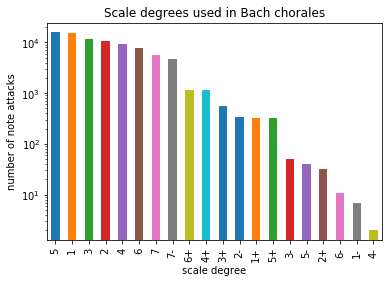

In [15]:
ax = series.value_counts().plot.bar(logy=True)
ax.set_xlabel("scale degree")
ax.set_ylabel("number of note attacks")
ax.set_title("Scale degrees used in Bach chorales");

Another plot variant is to display the categories horizontally using the *barh* plotting function:

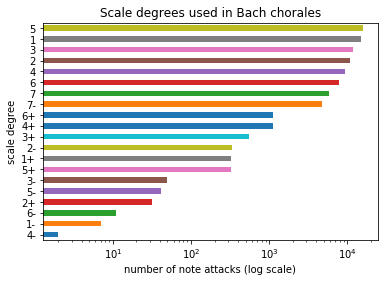

In [16]:
ax = series.value_counts(ascending=True).plot.barh(logx=True);
ax.set_ylabel("scale degree")
ax.set_xlabel("number of note attacks (log scale)")
ax.set_title("Scale degrees used in Bach chorales");

## Sorting categories by scale degree

Here is an example of how to sort categories on the plot by scale degree rather than frequency of the scale degrees.  First, define a function, called *sdorder*, that sorts the scale degrees in a musical fashion:

In [17]:
import re
def sdorder(s):
    p = re.compile("([0-9]+)([+-]?)")
    m = p.match(s)
    v = int(m.group(1)) * 10;
    if m.group(2) == '+':
        v += 1
    elif m.group(2) == '-':
        v -= 1
    return v
    
sdsequence = sorted(series.unique(), key=sdorder)
print(sdsequence)

['1-', '1', '1+', '2-', '2', '2+', '3-', '3', '3+', '4-', '4', '4+', '5-', '5', '5+', '6-', '6', '6+', '7-', '7']


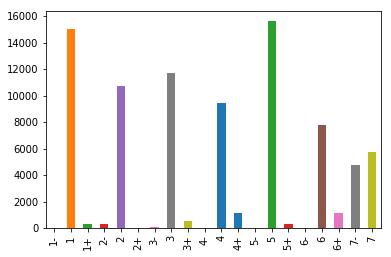

In [18]:
sdcategories = pd.api.types.CategoricalDtype(categories=sdsequence, ordered=True)
newseries = series.astype(sdcategories)
newseries.value_counts().sort_index().plot.bar();

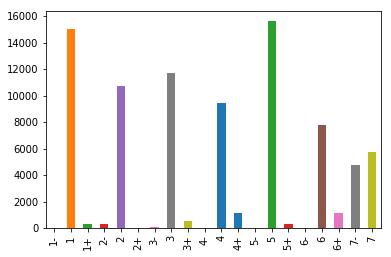

In [19]:
newseries = pd.Series(pd.Categorical(input, ordered=True, categories=sdsequence))
newseries.value_counts().sort_index().plot.bar();

## Saving figures to files

Plots can be saved to a file located in the same directory as the staring directory for the notebook (if the notebook is located on the Desktop, the saved figure will be placed on the desktop).  Notice how the output format is controlled by the filename extension.

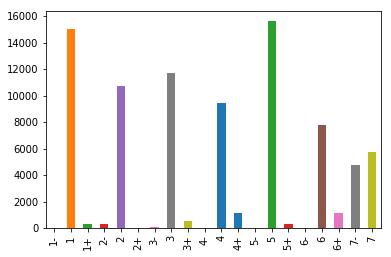

In [25]:
newseries = pd.Series(pd.Categorical(input, ordered=True, categories=sdsequence))
ax = newseries.value_counts().sort_index().plot.bar();
ax.get_figure().savefig("myplot.png")
ax.get_figure().savefig("myplot.svg")
ax.get_figure().savefig("myplot.pdf")

## Plotting scale degrees by vocal part

First extract the scale degree data by voice from the chorales:

In [28]:
input_bass = ! humcat -s h://chorales| extractx -s 1 | deg -at | serialize | ridx -H | egrep -v "=|r" 
input_tenor = ! humcat -s h://chorales| extractx -s 2 | deg -at | serialize | ridx -H | egrep -v "=|r" 
input_alto = ! humcat -s h://chorales| extractx -s 3 | deg -at | serialize | ridx -H | egrep -v "=|r" 
input_soprano = ! humcat -s h://chorales| extractx -s 4 | deg -at | serialize | ridx -H | egrep -v "=|r" 

Then create four panadas series for the data sorted by scale degree:

In [52]:
voices = [None] * 4
voices[0] = pd.Series(pd.Categorical(input_soprano, ordered=True, categories=sdsequence))
voices[1] = pd.Series(pd.Categorical(input_alto, ordered=True, categories=sdsequence))
voices[2] = pd.Series(pd.Categorical(input_tenor, ordered=True, categories=sdsequence))
voices[3] = pd.Series(pd.Categorical(input_bass, ordered=True, categories=sdsequence))


Finally create a figure with four subplots and fill it in:

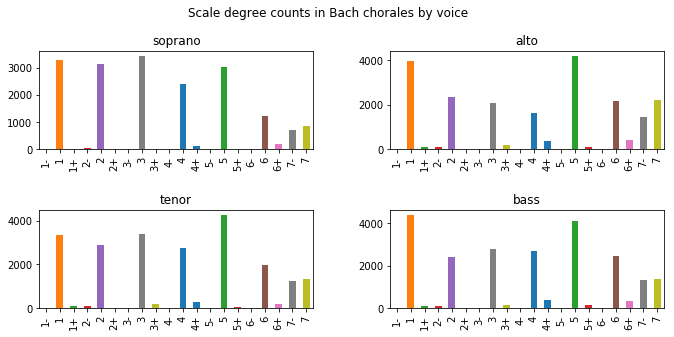

In [79]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0 = voices[0].value_counts().sort_index().plot.bar(ax=axes[0,0])
ax1 = voices[1].value_counts().sort_index().plot.bar(ax=axes[0,1])
ax2 = voices[2].value_counts().sort_index().plot.bar(ax=axes[1,0])
ax3 = voices[3].value_counts().sort_index().plot.bar(ax=axes[1,1])
ax0.set_title("soprano")
ax1.set_title("alto")
ax2.set_title("tenor")
ax3.set_title("bass")
fig.suptitle("Scale degree counts in Bach chorales by voice")
fig.tight_layout(rect=[0,0.03,1,0.95])
fig.set_size_inches(10,5)

Notice that the soprano part focuses on scale degrees 2, 3, and 4 much more than the alto or bass parts do.  The soprano focuses on the third slightly more than the root, and the tenor noticeably focuses on the 5th scale degree.

## Downloading Humdrum files to local disk

The previous examples always download the Bach chorales everytime they are needed for one of the command-line pipelines.  This does not happen too often (only 5 times in all of the above cells), but if you need to store a local copy, this section demonstrates how to do that.  In the following cell a directory called `~/Desktop/mychorales` is created, then the working location is changed to that directory, and then the chorales are downloaded with the [humsplit](http://extras.humdrum.org/man/humsplit) command.  The first two commands are [magic commands](http://ipython.readthedocs.io/en/stable/interactive/magics.html) for jupyter, but could also be done as regular shell commands like the third command, but prefixing the command with `!` rather than `%`.

In [102]:
%mkdir -p ~/Desktop/mychorales
%cd ~/Desktop/mychorales
!humsplit h://chorales
filelist = ! ls *.krn
print(filelist[0:5])

['chor001.krn', 'chor002.krn', 'chor003.krn', 'chor004.krn', 'chor005.krn']


Now the command pipeline can access the local copy of the chorales:

In [110]:
localinput = ! cat *.krn | deg -at | serialize | ridx -H | egrep -v "=|r" 
print(localinput[0:20])

['1', '1', '6', '7', '1', '5', '6', '4', '3', '2', '1', '5', '1', '7', '1', '2', '3', '4', '5', '1']


Alternatively, you can access the files by indicating the directory that they are stored in, rather than depending on being in a particular directory:

In [150]:
localinput2 = ! humcat -s ~/Desktop/mychorales/*.krn | deg -at | serialize | ridx -H | egrep -v "=|r" 
print(localinput2[0:20])

['1', '1', '6', '7', '1', '5', '6', '4', '3', '2', '1', '5', '1', '7', '1', '2', '3', '4', '5', '1']


## Comparison of major/minor modes

This section demonstrates how to group works by mode into major and minor keys.  In the previous sections, pitches were processed by scale degress, but in this section they are processed by pitch classes in terms of semitones relative to the tonic.  For example the tonic is 0, the second scale degree is 2, the 5th scale degree is 7, and so on.

First, create separate lists for the major and minor chorale files.  There are 177 chorales lin the major mode, and 193 in the minor mode:

In [117]:
minorfiles = ! egrep -l '^\*[a-g][-#]*:' ~/Desktop/mychorales/*.krn
len(minorfiles)

177

In [118]:
majorfiles = ! egrep -l '^\*[A-G][-#]*:' ~/Desktop/mychorales/*.krn
len(majorfiles)

193

In [119]:
len(minorfiles) + len(majorfiles)

370

Now that lists for the major and minor mode files have been created, use those lists to extract the pitch-class information for each subset of the chorales.  New commands in the pipeline are:

<p align="left">command | <p align="left">meaning 
:--- | :--- 
<p align="left"><tt>[cat](https://www.tecmint.com/13-basic-cat-command-examples-in-linux) \$filelist</tt></p> | <p align="left">Concatenate all of the filenames in the $filelist python string variable.
<p align="left"><tt>[transpose](http://extras.humdrum.org/man/transpose) -k c</tt></p> | <p align="left">Transpose the music to the key of C major/minor (requires a key designation in the files).
<p align="left"><tt>[kern](http://www.humdrum.org/Humdrum/commands/kern.html) -x</tt></p> | <p align="left">Remove all non-pitch information from `**kern` spine data.
<p align="left"><tt>[pc](http://www.humdrum.org/Humdrum/commands/pc.html) -x</tt></p> | <p align="left">Convert pitches into pitch-class numbers (C=0, C-sharp/D-flat=1, D=2, etc.)
<p align="left"><tt>[egrep](https://www.computerhope.com/unix/uegrep.htm) -v "[]=r_]"</tt></p> | <p align="left">Remove barlines (`=`), rests (`r`), ending tied notes (`]`) and intermediate tied notes(`_`).
<p align="left"><tt>[sed](http://www.grymoire.com/Unix/Sed.html) 's/\[//g'</tt></p> | <p align="left">Remove tie-start marker from analysis data.    





In [155]:
filelist = " ".join(majorfiles)
majorinput = ! cat $filelist | transpose -k c | kern -x | pc \
    | serialize | ridx -H | egrep -v "[]=r_]" | sed 's/\[//g'
print(majorinput[0:10])

['0', '0', '9', '11', '0', '7', '9', '5', '4', '2']


In [156]:
filelist = " ".join(minorfiles)
minorinput = ! cat $filelist | transpose -k c | kern -x | pc \
    | serialize | ridx -H | egrep -v "[]=|r_]" | sed 's/\[//g'
print(minorinput[0:10])

['7', '0', '2', '3', '2', '0', '11', '0', '7', '2']


For sorting purposes when creating the plots further below, the pitch classes should be converted from strings into integers.  This is done with the "`dtype=int`" option when creating the pandas series:

In [159]:
majorseries = pd.Series(data=majorinput, dtype=int)
minorseries = pd.Series(data=minorinput, dtype=int)

Now plot counts of the pitch class/scale degree data for each mode.  There are two plots generated for each mode (1) a list of the counts sorted by occurrence, and (2) a list in chromatic order.  Notice in particular that the third scale degree occurs at pc=4 in major modes, but pc=3 in minor modes.

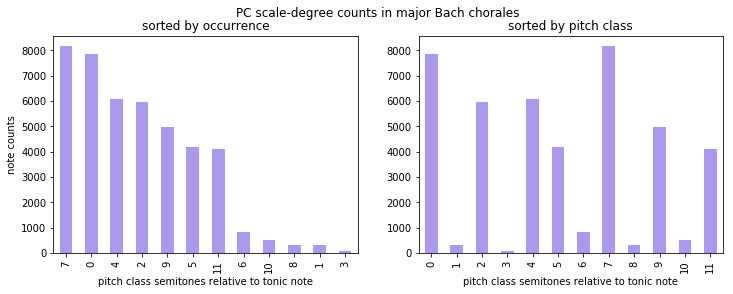

In [202]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2)
ax0 = majorseries.value_counts().plot.bar(ax=axes[0], color="#aa99ee")
ax1 = majorseries.value_counts().sort_index().plot.bar(ax=axes[1], color="#aa99ee")
ax0.set_title("sorted by occurrence")
ax1.set_title("sorted by pitch class")
ax0.set_xlabel("pitch class semitones relative to tonic note")
ax1.set_xlabel("pitch class semitones relative to tonic note")
ax0.set_ylabel("note counts")
fig.suptitle("PC scale-degree counts in major Bach chorales")
fig.set_size_inches(12,4)

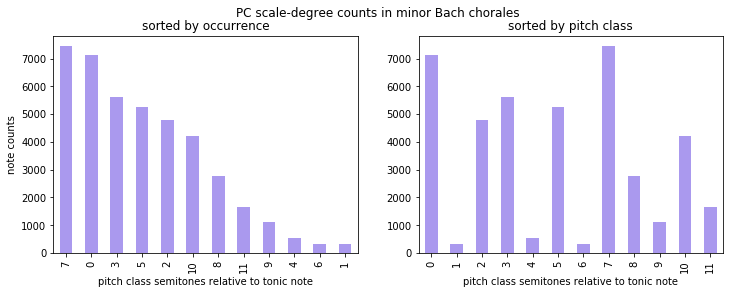

In [203]:
fig, axes = plt.subplots(ncols=2)
ax0 = minorseries.value_counts().plot.bar(ax=axes[0], color="#aa99ee")
ax1 = minorseries.value_counts().sort_index().plot.bar(ax=axes[1], color="#aa99ee")
ax0.set_title("sorted by occurrence")
ax1.set_title("sorted by pitch class")
ax0.set_xlabel("pitch class semitones relative to tonic note")
ax1.set_xlabel("pitch class semitones relative to tonic note")
ax0.set_ylabel("note counts")
fig.suptitle("PC scale-degree counts in minor Bach chorales")
fig.set_size_inches(12,4)

Plotting the major/minor plots side by side for each variant:

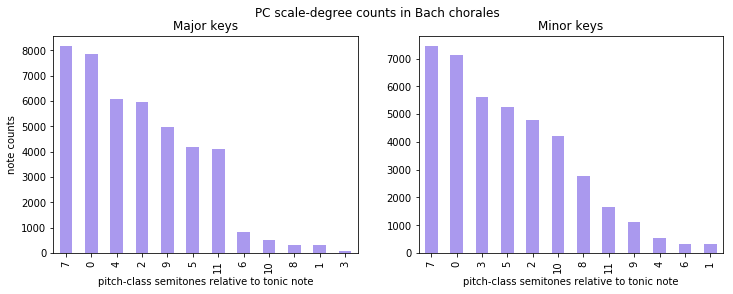

In [210]:
fig, axes = plt.subplots(ncols=2)
ax0 = majorseries.value_counts().plot.bar(ax=axes[0], color="#aa99ee")
ax1 = minorseries.value_counts().plot.bar(ax=axes[1], color="#aa99ee")
ax0.set_title("Major keys")
ax1.set_title("Minor keys")
ax0.set_xlabel("pitch-class semitones relative to tonic note")
ax1.set_xlabel("pitch-class semitones relative to tonic note")
ax0.set_ylabel("note counts")
fig.suptitle("PC scale-degree counts in Bach chorales")
fig.set_size_inches(12,4)

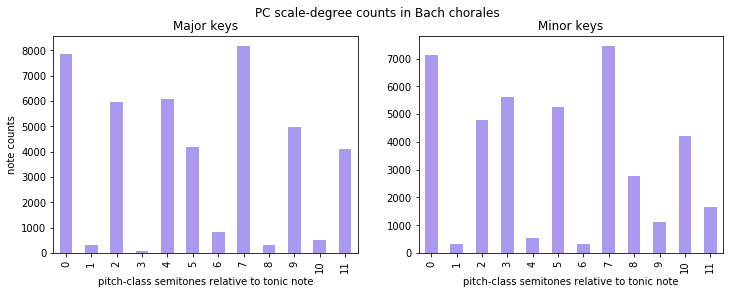

In [211]:
fig, axes = plt.subplots(ncols=2)
ax0 = majorseries.value_counts().sort_index().plot.bar(ax=axes[0], color="#aa99ee")
ax1 = minorseries.value_counts().sort_index().plot.bar(ax=axes[1], color="#aa99ee")
ax0.set_title("Major keys")
ax1.set_title("Minor keys")
ax0.set_xlabel("pitch-class semitones relative to tonic note")
ax1.set_xlabel("pitch-class semitones relative to tonic note")
ax0.set_ylabel("note counts")
fig.suptitle("PC scale-degree counts in Bach chorales")
fig.set_size_inches(12,4)

Below is an example of stacked plots to merge the two above plots into a single plot.  First the major and minor counts are extracted to separate lists:

In [241]:
majorhist = majorseries.value_counts().sort_index().tolist()
majorhist

[7876, 316, 5946, 88, 6078, 4181, 836, 8176, 333, 4977, 521, 4106]

In [222]:
minorhist = minorseries.value_counts().sort_index().tolist()
minorhist

[7115, 337, 4775, 5632, 555, 5254, 343, 7452, 2784, 1135, 4207, 1643]

Nomalize the difference between major and minor notecounts:

In [299]:
df = pd.DataFrame()
df["major"] = majorhist
df["minor"] = minorhist
df["major"] *= 100 / df["major"].sum()
df["minor"] *= 100 / df["minor"].sum()

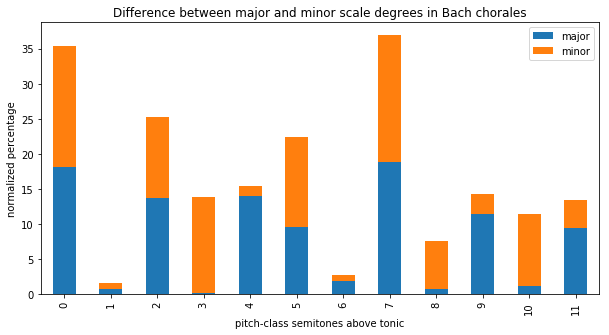

In [300]:
ax = df.plot.bar(stacked=True, figsize=(10,5))
ax.set_title("Difference between major and minor scale degrees in Bach chorales")
ax.set_ylabel("normalized percentage")
ax.set_xlabel("pitch-class semitones above tonic");

The largest difference is that major keys use the 4th semitone above tonic (major 3rd), while the minor keys use the 3rd semitone above the tonie (minor 3rd). Also semitones 8 and 10 are mostly used by minor keys, while 9 and 10 are used by major keys.  For major keys, there is more 6, probably as a leading tone to a tonicization of the dominant (7).  Minor key chorales also use more of the subdominant scale-degree (5).

## Beyond major and minor

The Bach choral sets has music in other modes besides major and minor.  For the above analyses, modes such as dorian are assigned to the minor category, and mixolydian chorales are assigned to the major category.  Here are the counts of chorales in non-manor/-minor modes:

In [278]:
# dorian mode
dorfiles = ! egrep -il '^\*[a-g][-#]*:dor' ~/Desktop/mychorales/*.krn
len(dorfiles)

37

In [277]:
# phrygian mode
phrfiles = ! egrep -il '^\*[a-g][-#]*:phr' ~/Desktop/mychorales/*.krn
len(phrfiles)

2

In [276]:
# lydian mode
lydfiles = ! egrep -il '^\*[a-g][-#]*:lyd' ~/Desktop/mychorales/*.krn
len(lydfiles)

0

In [275]:
# mixolydian mode
mixfiles = ! egrep -il '^\*[a-g][-#]*:mix' ~/Desktop/mychorales/*.krn
len(mixfiles)

9

In [274]:
# locrian mode
locfiles = ! egrep -il '^\*[a-g][-#]*:loc' ~/Desktop/mychorales/*.krn
len(locfiles)

0

In [279]:
# all non-major/-minor keys
modefiles = ! egrep -il '^\*[a-g][-#]*:[a-z][a-z][a-z]' ~/Desktop/mychorales/*.krn
len(modefiles)

48

Add the data from the 37 dorian files to the stacked scale-degree plot:

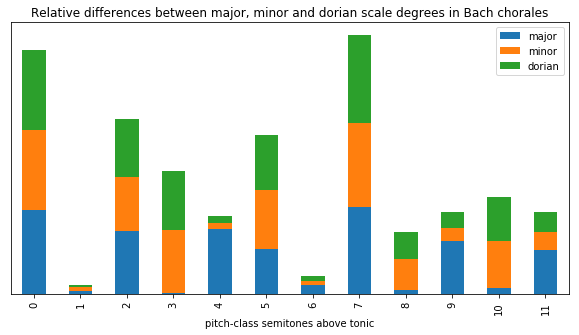

In [301]:
filelist = " ".join(dorfiles)
dorinput = ! cat $filelist | transpose -k c | kern -x | pc \
    | serialize | ridx -H | egrep -v "[]=|r_]" | sed 's/\[//g'
dorseries = pd.Series(data=dorinput, dtype=int)
dorhist = dorseries.value_counts().sort_index().tolist()
df["dorian"] = dorhist
df["dorian"] *= 100 / df["dorian"].sum()
ax = df.plot.bar(stacked=True, figsize=(10,5))
ax.set_title("Relative differences between major, minor and dorian scale degrees in Bach chorales")
ax.set_xlabel("pitch-class semitones above tonic")
ax.axes.get_yaxis().set_visible(False)

Here is a table of the data used to produce the plots.  Each column sums to 100%.

In [302]:
df

,major,minor,dorian
0,18.133260,17.256015,17.264121
1,0.727541,0.817326,0.510584
2,13.689736,11.580811,12.498670
3,0.202606,13.659294,12.785874
4,13.993646,1.346042,1.404106
5,9.626099,12.742530,11.988086
6,1.924759,0.831878,1.233911
7,18.823963,18.073341,18.966067
8,0.766680,6.752037,5.924902
9,11.458765,2.752716,3.467716


## Further reading for pandas

See [this documentation](https://pandas.pydata.org/pandas-docs/stable/visualization.html) for more plotting possibilities with pandas.  And the [API Reference](https://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-plotting) for pandas.

Review the  [Series](https://pandas.pydata.org/pandas-docs/stable/dsintro.html#series) which lists various functions that you can use for manipulation series data.

Blog dated 16 Mar 2017 about [Pandas & Seaborn](https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly)

[Seaborn aesthetics](https://seaborn.pydata.org/tutorial/aesthetics.html)

See [this documentation](https://seaborn.pydata.org/tutorial/categorical.html) about plotting categorical data with seaborn.